# Implementation of Deep Q Network for controling a two wheeled Self Balancing Robot

In this notebook, i have briefly shown the implementation of Deep Q network for a Gazebo robot model using ROS. The white paper . The paper can be accessed from  <a href=https://arxiv.org/pdf/1807.08272.pdf>here</a> . The video is available <a href= https://www.youtube.com/watch?v=OU7jb2B4L-c&t=17s>here</a>

importing libraries

In [19]:
from __future__ import division
import numpy as np
import pickle
import rospy
import sys
from geometry_msgs.msg import Twist
from sensor_msgs.msg import Imu
from std_srvs.srv import Empty
from nav_msgs.msg import Odometry
import time
import pandas as pd
from matplotlib import pyplot as plt
from collections import deque
import random
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam


```cmd_vel``` topic for publishing velocity commands to the robot </br>
```imu``` topic to subscribe to imu sensor readings 

In [ ]:
cmd_vel = "/cmd_vel"
Imu_topic = "/imu"

```SelfBalance``` class to initialize environment

In [21]:
class SelfBalance:
    def __init__(self):
        self.cmd_vel = rospy.Publisher(cmd_vel,Twist,queue_size =1)
        self.subscriber = rospy.Subscriber(Imu_topic,Imu,callback=self.imu_callback)
        self.reset = rospy.ServiceProxy("/gazebo/reset_simulation",Empty)
        self.pause = rospy.ServiceProxy("/gazebo/pause_physics",Empty)
        self.unpause = rospy.ServiceProxy("/gazebo/unpause_physics",Empty)
        #self.pose_sub = rospy.Subscriber('/ground_truth/state',Odometry,callback=self.pose_callback)
        self.i =0
        self.count =0
        self.vel=Twist()
        self.vel.linear.y = 0
        self.vel.linear.z = 0
        self.vel.angular.x =0
        self.vel.angular.y = 0
        self.vel.angular.z = 0
        self.y_angle =0

       
        #self.x=0
        #self.y=0

    def imu_callback(self,data):
        self.y_angle = data.orientation.y
        
        


Initializing Node

In [22]:
rospy.init_node('SelfBalance',anonymous=True)

In [23]:
rAll_list = []
gamma = 0.9
lr =0.7
vels = np.array([-200,-100,-50,-25,-10,10,25,50,100,200])

In [24]:
Robot = SelfBalance()

Resetting to initial state

In [25]:
Robot.reset()

Hyperparameters

In [ ]:
legal_actions=len(vels)
actions = vels.tolist()

num_episodes =1500
epsilon =1
epsilon_decay =0.999
memory_size =1000
batch_size=100
show=True
angles = np.arange(-0.314,0.315,0.314)

In [27]:
legal_actions

10

In [28]:
scale=180/3.14

limiting the maximum rotation , upto about 5 degreees

In [29]:
iters =2000
limit =0.085*scale

In [30]:
scale

57.324840764331206

Experience Replay

In [31]:
memory = deque(maxlen=memory_size)
Robot.reset()
time.sleep(1)
Robot.pause()
s=Robot.y_angle*scale
Robot.unpause()
a = vels[np.random.randint(0,legal_actions)]
Robot.vel.linear.x=a
Robot.cmd_vel.publish(Robot.vel)
Robot.pause()
s1=Robot.y_angle*scale
if abs(s1)<=limit:
    r=1
    experience =(s,r,a,s1)
    s=s1
else:
    r=-100
    Robot.reset()
    experience =(s,r,a,s1)
    s=Robot.y_angle

memory.append(experience)
Robot.unpause()

for _ in range(memory_size):
    a = vels[np.random.randint(0,legal_actions)]
    Robot.vel.linear.x=a
    Robot.cmd_vel.publish(Robot.vel)
    Robot.pause()
    s1=Robot.y_angle
    if abs(s1)<=limit:
        r=1
        experience =(s,r,a,s1)
        s=s1
    else:
        r=-100
        Robot.reset()
        experience =(s,r,a,s1)
        s=Robot.y_angle
    memory.append(experience)
    Robot.unpause()



In [32]:
memory

deque([(0.0807146917870581, 1, -10, 0.002722051169501035),
       (0.002722051169501035, 1, -10, 0.003002241528303411),
       (0.003002241528303411, 1, -100, 0.003278289322991704),
       (0.003278289322991704, 1, 25, 0.003550258429904102),
       (0.003550258429904102, 1, -100, 0.0036847328268735575),
       (0.0036847328268735575, 1, 50, 0.003818210548065529),
       (0.003818210548065529, 1, -100, 0.003950699045258258),
       (0.003950699045258258, 1, -200, 0.00421273775920348),
       (0.00421273775920348, 1, 200, 0.004342302484636279),
       (0.004342302484636279, 1, 10, 0.004598558438761661),
       (0.004598558438761661, 1, 25, 0.004725263789160994),
       (0.004725263789160994, 1, 10, 0.004851030041033252),
       (0.004851030041033252, 1, -50, 0.005099772884452474),
       (0.005099772884452474, 1, -50, 0.00558629056383006),
       (0.00558629056383006, 1, 100, 0.005705674138519827),
       (0.005705674138519827, 1, -100, 0.006058540400869336),
       (0.006058540400869336

In [33]:
if True:
    batches=random.sample(memory,batch_size)
    states= np.array([batch[0] for batch in batches])
    rewards= np.array([batch[1] for batch in batches])
    actions= np.array([batch[2] for batch in batches])
    new_states= np.array([batch[3] for batch in batches])

Our DQN model architecture

In [34]:
model = Sequential()
model.add(Dense(40,activation='relu',input_shape=(1,)))
model.add(Dense(40,activation='relu'))
model.add(Dense(legal_actions,activation='linear'))
model.compile(loss='mean_absolute_error',optimizer=Adam(lr=0.01),)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 40)                80        
_________________________________________________________________
dense_5 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                410       
Total params: 2,130
Trainable params: 2,130
Non-trainable params: 0
_________________________________________________________________


In [35]:
Robot.y_angle

0.05729390431268697

In [36]:
for i in range(num_episodes):
    
    Robot.reset()
    time.sleep(1)
    Robot.pause()
    s= Robot.y_angle*scale
    
    rAll =0
    r=0
    d = False
    j = 0
    
    for j in range(iters):
    #while True:
        #j=j+1
        #epsilon greedy. to choose random actions initially when Q is all zeros
        if np.random.random()< epsilon:
            a = vels[np.random.randint(0,legal_actions)]
            epsilon = epsilon*epsilon_decay
        else:
            Q = model.predict(np.array([s]))
            a =vels[np.argmax(Q)]
        Robot.vel.linear.x = a
        Robot.unpause()
        Robot.cmd_vel.publish(Robot.vel)
        s1 =Robot.y_angle*scale
        Robot.pause()
        if abs(s1)>limit:
            d = True
            
        else:
            d = False
            r=1
        
        
        rAll=rAll+r
        
        
        if d:
            #time.sleep(1)
            if rAll<(iters-1):
                r =-100
                experience =(s,r,a,s1)
                memory.append(experience)
                if rAll !=0:
                    print("Episode %d Failed! Reward %d"%(i,rAll))
            rAll_list.append((i,rAll))
            
            break
        experience=(s,r,a,s1)
        memory.append(experience)
        if j>=(iters-1):
            print("Episode %d Passed! Reward %d after full episode"%(i,rAll))
            rAll_list.append((i,rAll))
            break
            
        s = s1
        #print("State %d"%s)
        Robot.unpause()
    batches=random.sample(memory,batch_size)
    states= np.array([batch[0] for batch in batches])
    rewards= np.array([batch[1] for batch in batches])
    actions= np.array([batch[2] for batch in batches])
    new_states= np.array([batch[3] for batch in batches])
    Qs =model.predict(states)
    new_Qs = model.predict(new_states)
    for i in range(len(rewards)):
        action_index=list(vels).index(actions[i])
        if rewards[i]==-100:
            Qs[i][action_index]=Qs[i][action_index]+ lr*(rewards[i])
        else:
            Qs[i][action_index]= Qs[i][action_index]+ lr*(rewards[i]+gamma*np.max(new_Qs[i]))
    model.fit(states,Qs,verbose=0)
    #epsilon = epsilon*epsilon_decay
    

Episode 0 Failed! Reward 28
Episode 2 Failed! Reward 63
Episode 4 Failed! Reward 66
Episode 6 Failed! Reward 139
Episode 8 Failed! Reward 86
Episode 10 Failed! Reward 136
Episode 12 Failed! Reward 215
Episode 14 Failed! Reward 68
Episode 16 Failed! Reward 184
Episode 18 Failed! Reward 181
Episode 20 Failed! Reward 110
Episode 22 Failed! Reward 134
Episode 23 Failed! Reward 673
Episode 25 Failed! Reward 821
Episode 27 Failed! Reward 1483
Episode 29 Failed! Reward 1610
Episode 31 Passed! Reward 2000 after full episode
Episode 32 Failed! Reward 1200
Episode 34 Failed! Reward 499
Episode 35 Failed! Reward 1552
Episode 37 Failed! Reward 1530
Episode 39 Passed! Reward 2000 after full episode
Episode 40 Passed! Reward 2000 after full episode
Episode 41 Passed! Reward 2000 after full episode
Episode 42 Passed! Reward 2000 after full episode
Episode 43 Passed! Reward 2000 after full episode
Episode 44 Failed! Reward 972
Episode 46 Passed! Reward 2000 after full episode
Episode 47 Passed! Reward

Episode 195 Passed! Reward 2000 after full episode
Episode 196 Passed! Reward 2000 after full episode
Episode 197 Passed! Reward 2000 after full episode
Episode 198 Passed! Reward 2000 after full episode
Episode 199 Passed! Reward 2000 after full episode
Episode 200 Passed! Reward 2000 after full episode
Episode 201 Passed! Reward 2000 after full episode
Episode 202 Passed! Reward 2000 after full episode
Episode 203 Passed! Reward 2000 after full episode
Episode 204 Passed! Reward 2000 after full episode
Episode 205 Passed! Reward 2000 after full episode
Episode 206 Passed! Reward 2000 after full episode
Episode 207 Passed! Reward 2000 after full episode
Episode 208 Passed! Reward 2000 after full episode
Episode 209 Passed! Reward 2000 after full episode
Episode 210 Passed! Reward 2000 after full episode
Episode 211 Passed! Reward 2000 after full episode
Episode 212 Passed! Reward 2000 after full episode
Episode 213 Passed! Reward 2000 after full episode
Episode 214 Passed! Reward 2000

Episode 358 Passed! Reward 2000 after full episode
Episode 359 Passed! Reward 2000 after full episode
Episode 360 Passed! Reward 2000 after full episode
Episode 361 Passed! Reward 2000 after full episode
Episode 362 Passed! Reward 2000 after full episode
Episode 363 Passed! Reward 2000 after full episode
Episode 364 Passed! Reward 2000 after full episode
Episode 365 Passed! Reward 2000 after full episode
Episode 366 Passed! Reward 2000 after full episode
Episode 367 Passed! Reward 2000 after full episode
Episode 368 Passed! Reward 2000 after full episode
Episode 369 Passed! Reward 2000 after full episode
Episode 370 Passed! Reward 2000 after full episode
Episode 371 Passed! Reward 2000 after full episode
Episode 372 Passed! Reward 2000 after full episode
Episode 373 Passed! Reward 2000 after full episode
Episode 374 Passed! Reward 2000 after full episode
Episode 375 Passed! Reward 2000 after full episode
Episode 376 Passed! Reward 2000 after full episode
Episode 377 Passed! Reward 2000

Episode 519 Passed! Reward 2000 after full episode
Episode 520 Passed! Reward 2000 after full episode
Episode 521 Passed! Reward 2000 after full episode
Episode 522 Passed! Reward 2000 after full episode
Episode 523 Passed! Reward 2000 after full episode
Episode 524 Passed! Reward 2000 after full episode
Episode 525 Passed! Reward 2000 after full episode
Episode 526 Passed! Reward 2000 after full episode
Episode 527 Passed! Reward 2000 after full episode
Episode 528 Passed! Reward 2000 after full episode
Episode 529 Passed! Reward 2000 after full episode
Episode 530 Passed! Reward 2000 after full episode
Episode 531 Passed! Reward 2000 after full episode
Episode 532 Passed! Reward 2000 after full episode
Episode 533 Passed! Reward 2000 after full episode
Episode 534 Passed! Reward 2000 after full episode
Episode 535 Passed! Reward 2000 after full episode
Episode 536 Passed! Reward 2000 after full episode
Episode 537 Passed! Reward 2000 after full episode
Episode 538 Passed! Reward 2000

Episode 682 Passed! Reward 2000 after full episode
Episode 683 Passed! Reward 2000 after full episode
Episode 684 Passed! Reward 2000 after full episode
Episode 685 Passed! Reward 2000 after full episode
Episode 686 Passed! Reward 2000 after full episode
Episode 687 Passed! Reward 2000 after full episode
Episode 688 Passed! Reward 2000 after full episode
Episode 689 Passed! Reward 2000 after full episode
Episode 690 Passed! Reward 2000 after full episode
Episode 691 Passed! Reward 2000 after full episode
Episode 692 Passed! Reward 2000 after full episode
Episode 693 Passed! Reward 2000 after full episode
Episode 694 Passed! Reward 2000 after full episode
Episode 695 Passed! Reward 2000 after full episode
Episode 696 Passed! Reward 2000 after full episode
Episode 697 Passed! Reward 2000 after full episode
Episode 698 Passed! Reward 2000 after full episode
Episode 699 Passed! Reward 2000 after full episode
Episode 700 Passed! Reward 2000 after full episode
Episode 701 Passed! Reward 2000

Episode 843 Passed! Reward 2000 after full episode
Episode 844 Passed! Reward 2000 after full episode
Episode 845 Passed! Reward 2000 after full episode
Episode 846 Passed! Reward 2000 after full episode
Episode 847 Passed! Reward 2000 after full episode
Episode 848 Passed! Reward 2000 after full episode
Episode 849 Passed! Reward 2000 after full episode
Episode 850 Passed! Reward 2000 after full episode
Episode 851 Passed! Reward 2000 after full episode
Episode 852 Passed! Reward 2000 after full episode
Episode 853 Passed! Reward 2000 after full episode
Episode 854 Passed! Reward 2000 after full episode
Episode 855 Passed! Reward 2000 after full episode
Episode 856 Passed! Reward 2000 after full episode
Episode 857 Passed! Reward 2000 after full episode
Episode 858 Passed! Reward 2000 after full episode
Episode 859 Passed! Reward 2000 after full episode
Episode 860 Passed! Reward 2000 after full episode
Episode 861 Passed! Reward 2000 after full episode
Episode 862 Passed! Reward 2000

Episode 1004 Passed! Reward 2000 after full episode
Episode 1005 Passed! Reward 2000 after full episode
Episode 1006 Passed! Reward 2000 after full episode
Episode 1007 Passed! Reward 2000 after full episode
Episode 1008 Passed! Reward 2000 after full episode
Episode 1009 Passed! Reward 2000 after full episode
Episode 1010 Passed! Reward 2000 after full episode
Episode 1011 Passed! Reward 2000 after full episode
Episode 1012 Passed! Reward 2000 after full episode
Episode 1013 Passed! Reward 2000 after full episode
Episode 1014 Passed! Reward 2000 after full episode
Episode 1015 Passed! Reward 2000 after full episode
Episode 1016 Passed! Reward 2000 after full episode
Episode 1017 Failed! Reward 1403
Episode 1019 Passed! Reward 2000 after full episode
Episode 1020 Passed! Reward 2000 after full episode
Episode 1021 Passed! Reward 2000 after full episode
Episode 1022 Passed! Reward 2000 after full episode
Episode 1023 Passed! Reward 2000 after full episode
Episode 1024 Passed! Reward 200

Episode 1164 Passed! Reward 2000 after full episode
Episode 1165 Passed! Reward 2000 after full episode
Episode 1166 Passed! Reward 2000 after full episode
Episode 1167 Passed! Reward 2000 after full episode
Episode 1168 Passed! Reward 2000 after full episode
Episode 1169 Passed! Reward 2000 after full episode
Episode 1170 Passed! Reward 2000 after full episode
Episode 1171 Passed! Reward 2000 after full episode
Episode 1172 Passed! Reward 2000 after full episode
Episode 1173 Passed! Reward 2000 after full episode
Episode 1174 Passed! Reward 2000 after full episode
Episode 1175 Passed! Reward 2000 after full episode
Episode 1176 Passed! Reward 2000 after full episode
Episode 1177 Passed! Reward 2000 after full episode
Episode 1178 Passed! Reward 2000 after full episode
Episode 1179 Passed! Reward 2000 after full episode
Episode 1180 Passed! Reward 2000 after full episode
Episode 1181 Passed! Reward 2000 after full episode
Episode 1182 Passed! Reward 2000 after full episode
Episode 1183

Episode 1322 Passed! Reward 2000 after full episode
Episode 1323 Passed! Reward 2000 after full episode
Episode 1324 Passed! Reward 2000 after full episode
Episode 1325 Passed! Reward 2000 after full episode
Episode 1326 Passed! Reward 2000 after full episode
Episode 1327 Passed! Reward 2000 after full episode
Episode 1328 Passed! Reward 2000 after full episode
Episode 1329 Passed! Reward 2000 after full episode
Episode 1330 Passed! Reward 2000 after full episode
Episode 1331 Passed! Reward 2000 after full episode
Episode 1332 Passed! Reward 2000 after full episode
Episode 1333 Passed! Reward 2000 after full episode
Episode 1334 Passed! Reward 2000 after full episode
Episode 1335 Passed! Reward 2000 after full episode
Episode 1336 Passed! Reward 2000 after full episode
Episode 1337 Passed! Reward 2000 after full episode
Episode 1338 Passed! Reward 2000 after full episode
Episode 1339 Passed! Reward 2000 after full episode
Episode 1340 Passed! Reward 2000 after full episode
Episode 1341

Episode 1481 Passed! Reward 2000 after full episode
Episode 1482 Passed! Reward 2000 after full episode
Episode 1483 Passed! Reward 2000 after full episode
Episode 1484 Passed! Reward 2000 after full episode
Episode 1485 Passed! Reward 2000 after full episode
Episode 1486 Passed! Reward 2000 after full episode
Episode 1487 Passed! Reward 2000 after full episode
Episode 1488 Passed! Reward 2000 after full episode
Episode 1489 Passed! Reward 2000 after full episode
Episode 1490 Passed! Reward 2000 after full episode
Episode 1491 Passed! Reward 2000 after full episode
Episode 1492 Passed! Reward 2000 after full episode
Episode 1493 Passed! Reward 2000 after full episode
Episode 1494 Passed! Reward 2000 after full episode
Episode 1495 Passed! Reward 2000 after full episode
Episode 1496 Passed! Reward 2000 after full episode
Episode 1497 Passed! Reward 2000 after full episode
Episode 1498 Passed! Reward 2000 after full episode
Episode 1499 Passed! Reward 2000 after full episode


In [41]:
def moving_average (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

Performance curve

In [44]:
eps =[ep for (ep,_) in rAll_list]
rewards=[reward for (_,reward) in rAll_list]

In [45]:
rewards = moving_average(rewards,100)

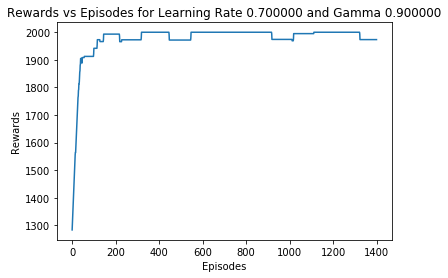

In [46]:
plot =plt.plot(rewards)
plt.ylabel('Rewards')
plt.xlabel('Episodes')
plt.title('Rewards vs Episodes for Learning Rate %f and Gamma %f'%(lr,gamma))
plt.savefig('Plot_with_lr_%f_gamma_%f_DQN.jpg'%(lr,gamma))

In [47]:
import pickle as pkl

In [48]:
pkl.dump(rAll_list,open('Rewards_with_lr_%f_gamma_%f_DQN.pkl'%(lr,gamma),'w'))

In [51]:
model_json = model.to_json()
with open("model2_lr_%f_episodes_%d.json"%(lr,num_episodes), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model2_lr_%f_episodes_%d.h5"%(lr,num_episodes))
print("Saved model to disk")
 

Saved model to disk
